# pyFAI-tutorial User Meeting 2024
Create azimuthal integrator from a .poni file, and perform integrations

#### Import modules

In [1]:
from pyFAI import load
from pyFAI.gui import jupyter
from pyFAI.app.integrate import process
import fabio
import time
import numpy as np
import sys, os
import json

#### Load the paths of .poni file, data file (.h5) and mask

In [2]:
PONI_PATH = "eiger.poni"
DATA_PATH = "Eiger2_CeO2_75keV.h5"
MASK_PATH = "eiger_mask.edf"

#### Load the data array and the mask array

In [3]:
container_imgs = fabio.open(DATA_PATH)
data0 = container_imgs.get_frame(0).data
mask_array = fabio.open(MASK_PATH).data

#### Instanciate the azimuthal integrator

In [4]:
ai = load(PONI_PATH)

In [5]:
ai

Detector Eiger2 4M	 PixelSize= 7.500e-05, 7.500e-05 m	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 4.182632e-01 m	PONI= 1.275493e-01, 4.730591e-02 m	rot1=-0.006347  rot2=-0.001755  rot3=-0.000002 rad
DirectBeamDist= 418.272 mm	Center: x=666.142, y=1690.871 pix	Tilt= 0.377° tiltPlanRotation= -15.455° 𝛌= 0.165Å

#### Integrate to a 1d dimensional profile with 2000 data points

In [6]:
NPT = 2000

In [7]:
res1d = ai.integrate1d(
    data=data0,
    npt=NPT,
    mask=mask_array,
)

#### Plot the result 1d

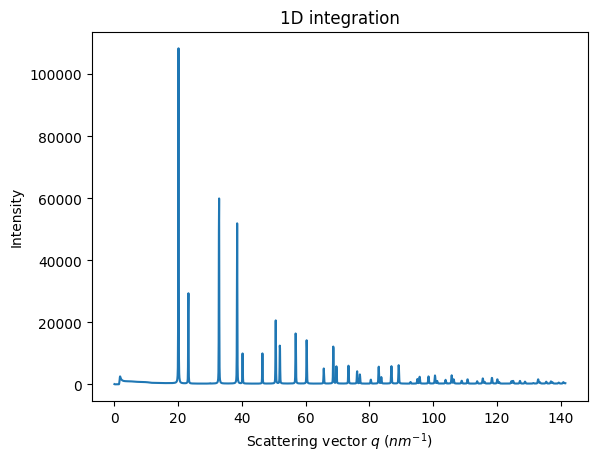

In [8]:
jupyter.plot1d(result=res1d)
pass

#### Change some attributes of integrate1d

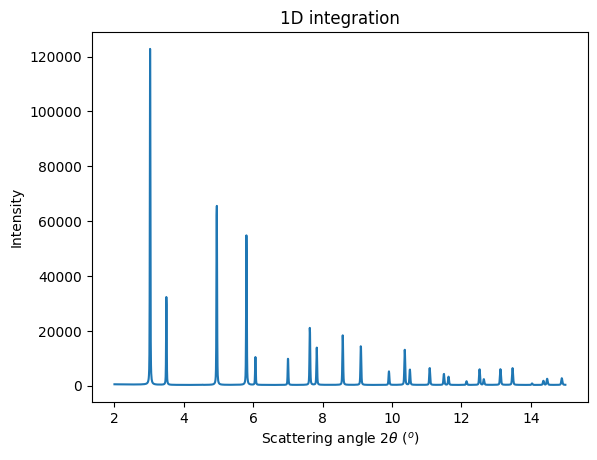

In [9]:
res1d = ai.integrate1d(
    data=data0,
    npt=NPT,
    mask=mask_array,
    unit="2th_deg",
    radial_range=[2,15],
    azimuth_range=[-90,0],
)
jupyter.plot1d(result=res1d)
pass

#### Change the method of integration and benchmark its speed looping the integration 20 times

In [10]:
method_python = ("bbox", "csr", "python")
method_cython = ("bbox", "csr", "cython")
method_opencl = ("bbox", "csr", "opencl")

In [11]:
# First, initialize the method once, before the loop
res1d_python = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_python)
st = time.perf_counter()
for _ in range(20):
    res1d_python = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_python)
print(f"The timing using python implementation is {time.perf_counter()-st} s.")

The timing using python implementation is 2.0795689271762967 s.


In [12]:
# First, initialize the method once, before the loop
res1d_cython = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_cython)
st = time.perf_counter()
for _ in range(20):
    res1d_cython = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_cython)
print(f"The timing using cython implementation is {time.perf_counter()-st} s.")

The timing using cython implementation is 1.4987276159226894 s.


In [13]:
# First, initialize the method once, before the loop
res1d_ocl = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_opencl)
st = time.perf_counter()
for _ in range(20):
    res1d_ocl = ai.integrate1d(data=data0, npt=NPT, mask=mask_array, method=method_opencl)
print(f"The timing using OpenCL implementation is {time.perf_counter()-st} s.")

The timing using OpenCL implementation is 0.10278486600145698 s.


#### Adding a dummy flat field correction (efficiencies of the pixels), a normalization factor of 1e6, and horizontal polarization

In [14]:
flat_field = np.random.random(size=data0.shape)

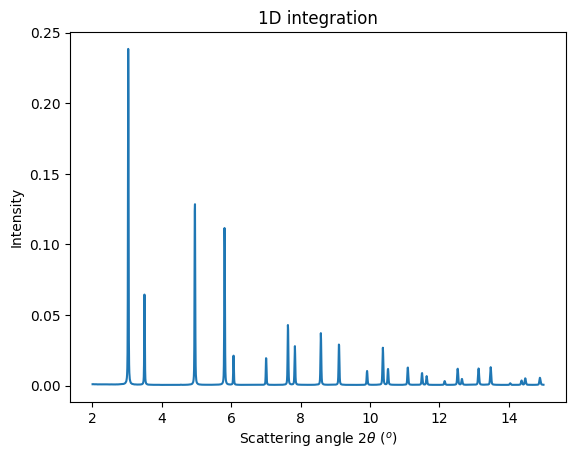

In [15]:
res1d = ai.integrate1d(
    data=data0,
    npt=NPT,
    mask=mask_array,
    unit="2th_deg",
    radial_range=[2,15],
    azimuth_range=[-90,0],
    method=method_opencl,
    flat=flat_field,
    normalization_factor=1e6,
    polarization_factor=0.99,
)
jupyter.plot1d(result=res1d)
pass

#### Saving the file

In [16]:
OUTPUT_FILE = "Eiger2_CeO2_75keV_out.dat"
res1d = ai.integrate1d(
    data=data0,
    npt=NPT,
    mask=mask_array,
    unit="2th_deg",
    radial_range=[2,15],
    azimuth_range=[-90,0],
    method=method_opencl,
    flat=flat_field,
    normalization_factor=1e6,
    polarization_factor=0.99,
    filename=OUTPUT_FILE,
)

### 2d integration

In [17]:
res2d = ai.integrate2d(
    data=data0,
    npt_rad=NPT,
    npt_azim=90,
    mask=mask_array,
    unit="2th_deg",
    radial_range=[2,15],
    azimuth_range=[-90,0],
    method=method_opencl,
    flat=flat_field,
    normalization_factor=1e6,
    polarization_factor=0.99,
)

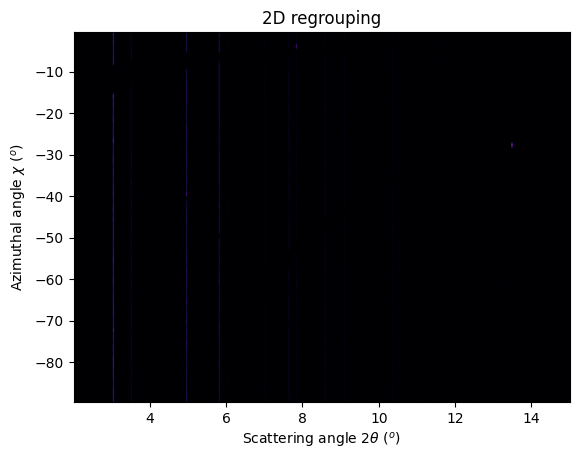

In [18]:
jupyter.plot2d(result=res2d)
pass

#### Open the integration GUI to save the .json file with integration parameters

In [19]:
os.system("pyFAI-integrate")

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pyFAI.method_registry:Degrading method from Method(dim=1, split='pseudo', algo='histogram', impl='*', target=None) -> Method(dim=1, split='bbox', algo='histogram', impl='*', target=None)
ERROR:pyFAI.gui.IntegrationDialog:No such file: .azimint.json


0

#### Load the configuration from the json file

In [20]:
with open("integrate1d.json") as f:
    config = json.load(f)

#### Run the integration cycle without opening the GUI
Be aware that the input_data attribute is a list (of one element in this case)

In [21]:
process(
    input_data=[DATA_PATH],
    config=config,
    output=None,
    monitor_name=None,
    observer=None,
)

0

#### Open the silx viewer with the output file

In [22]:
os.system("silx view Eiger2_CeO2_75keV_1d.h5")

0